load packages

In [1]:
import pandas as pd
import glob
import numpy as np
import math

from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)

import pandas as pd
from prophet import Prophet
import datetime

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

from scipy import stats
from scipy.special import boxcox1p, inv_boxcox1p
from itertools import product
 
from scipy.stats import kstest

# Data preparation

First we load the dataset, then we transform the date variable to date-time formate and change the column names of the date and target variable to ds and y. Then we drop the AvgSerice variable as we do not which to use this.

In [4]:
df = pd.read_csv(r'C:\Users\Britt\Documents\DataAnalyse\data\half_hour.txt', sep="\t")
df.date = pd.date_range(df.date[0] , periods = len(df.date), freq='30min')
df.rename(columns={'date' : 'ds', 'count' : 'y'}, inplace=True)
df.drop(['AvgService'], axis=1, inplace=True)

Split the dataset

In [5]:
len_trainset = round(0.8*len(df))
train = df.iloc[:len_trainset,:]
#test data
test = df.iloc[len_trainset:,:]

# Prophet

In [7]:
m = Prophet()
m.add_regressor('irregular')
m.add_regressor('holiday')
m.add_regressor('DeliverD1')
m.add_regressor('DeliverD7')
m.add_regressor('DeliverD14')
m.add_regressor('DeliverD21')
m.add_regressor('Bill1')
m.add_regressor('Bill7')
m.add_regressor( 'Bill14')
m.add_regressor('Bill21')
m.add_regressor('Deliver')

m.fit(train)

10:01:41 - cmdstanpy - INFO - Chain [1] start processing
10:01:44 - cmdstanpy - INFO - Chain [1] done processing


create future dates

In [12]:
future = m.make_future_dataframe(periods=len(test.ds), freq='30T')
future = pd.concat([future, df.iloc[:,2:]], axis=1)

In [13]:
future.head()

,ds,irregular,holiday,y,DeliverD1,DeliverD7,DeliverD14,DeliverD21,Bill1,Bill7,Bill14,Bill21,Deliver
0,2004-02-14 00:00:00,0,0,55,0,0,0,0,0,0,0,0,0
1,2004-02-14 00:30:00,0,0,63,0,0,0,0,0,0,0,0,0
2,2004-02-14 01:00:00,0,0,32,0,0,0,0,0,0,0,0,0
3,2004-02-14 01:30:00,0,0,38,0,0,0,0,0,0,0,0,0
4,2004-02-14 02:00:00,0,0,19,0,0,0,0,0,0,0,0,0


predict

In [14]:
forecast = m.predict(future)

# Results

In [15]:
predictions = forecast.yhat
y_true_train = df['y'][:len_trainset]
y_true_test = df['y'][len_trainset:]
y_pred_train = predictions[:len_trainset]
y_pred_test = predictions[len_trainset:]

MAEtrain = mean_absolute_error(y_true_train, y_pred_train)
MAEtest = mean_absolute_error(y_true_test, y_pred_test)
print('train MAE', MAEtrain)
print('test MAE', MAEtest)

train MAE 57.47066160370161
test MAE 55.51080717651045


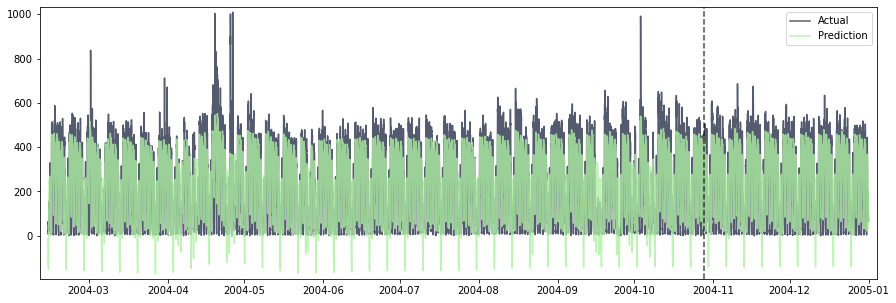

In [16]:
plt.plot(np.asarray(df.ds, dtype='datetime64[s]'), df.y, color= '#555B6E', label = 'Actual')
plt.plot(np.asarray(df.ds, dtype='datetime64[s]'), predictions, color='#aef0a3', label = 'Prediction', alpha=0.8)
plt.axvline(x=np.asarray(df.ds, dtype='datetime64[s]')[len_trainset], color='k', linestyle='--', alpha=0.7)
plt.margins(x=0.01)
plt.margins(y=0.02)
plt.legend()

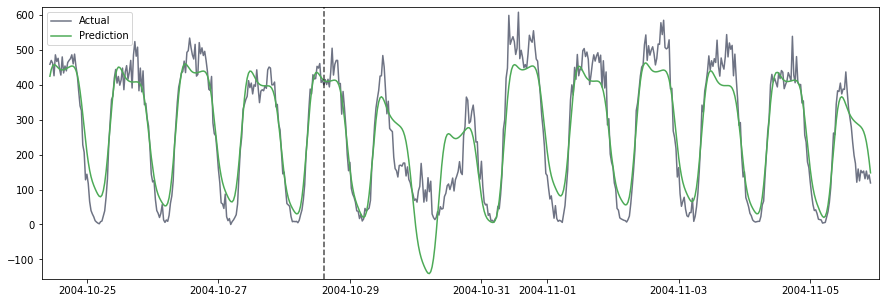

In [18]:
zoom1 = 200 #amount of observation from the train set you see
zoom2 = 400 #amount of observation from test you see

plt.rcParams["figure.figsize"] = (15,5)
fig = plt.figure()

plt.plot(np.asarray(df.ds, dtype='datetime64[s]')[len_trainset-zoom1:len_trainset+zoom2], df.y[len_trainset-zoom1:len_trainset+zoom2], color= '#555B6E', label = 'Actual', alpha=0.85)
plt.plot(np.asarray(df.ds, dtype='datetime64[s]')[len_trainset-zoom1:len_trainset+zoom2], predictions[len_trainset-zoom1:len_trainset+zoom2], color='#4DAA57', label = 'Prediction', alpha=1)
plt.axvline(x=np.asarray(df.ds, dtype='datetime64[s]')[len_trainset], color='k', linestyle='--', alpha=0.7)
plt.legend(loc="upper left")
plt.margins(x=0.01)
plt.margins(y=0.02)